# Introduction to Deep Learning

Please, make a copy of this colaboratory in order to be able to make changes **(File -> Save a copy in Drive)**.

## Homework #3

This colaboratory also contains Homework #3 of the Machine Learning course, which is due **April 2, midnight (23:59 EET time)**. To complete the homework, extract **(File -> Download .ipynb)** and submit to the course webpage.

**NB! Links to your colaboratory will not be accepted as a solution!**

In [0]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

Here we will define few functions that will help us visualise classifiers that we are going to build in this class:

In [45]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# for very shallow models
def plot_classifier(X, y, W, b):
  h = 0.02
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
  Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
  Z = np.argmax(Z, axis=1)
  Z = Z.reshape(xx.shape)
  fig = plt.figure()
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=120, edgecolors = 'white', cmap=plt.cm.Spectral)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

# for two-layer network 
def plot_neural_network(X, y, W,b ,W2, b2):
  h = 0.02
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
  Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
  Z = np.argmax(Z, axis=1)
  Z = Z.reshape(xx.shape)
  fig = plt.figure()
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=120, edgecolors = 'white', cmap=plt.cm.Spectral)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Let's generate some 2D data like in the lecture

In [0]:
N = 100 # number of points per class
D = 2 # dimensionality
K = 2 # number of classes (purple and red circles)
X = np.zeros((N*K,D)) # data matrix (each row = single example)
num_examples = X.shape[0]
y = np.zeros(N*K, dtype='uint8') # class labels

In [0]:
# Adding some geometry
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

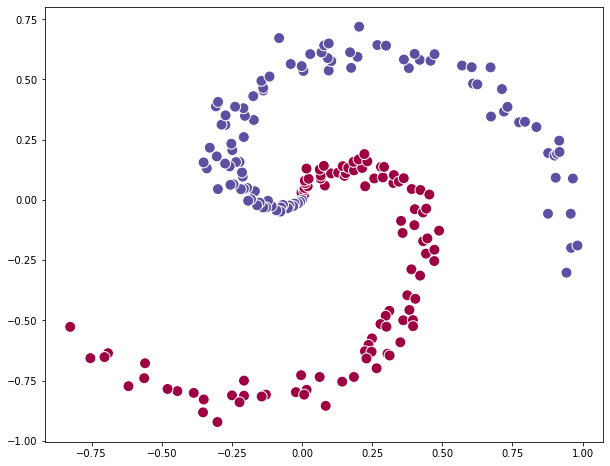

In [48]:
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=120, edgecolors = 'white', cmap=plt.cm.Spectral)
plt.show()

For our implementation we would need to transform the vector of correct labels `y` into one hot encoded matrix, let's call it `truth`.

In [49]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=uint8)

In [0]:
truth = np.zeros((len(y), D))
truth[np.arange(len(truth)), y] = 1

In [51]:
truth[0:5,]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

##Step by step training two artificial neurons
Here we create one neuron per each class, with baises, but **without activation function**.

In [0]:
# initialize weights and biases randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

Compute the answers by multiplying inputs with weights and adding biases. 

There are two competing functions for multiplying matrices: `np.matmul` and `np.dot`, there are [two important differences](https://stackoverflow.com/questions/34142485/difference-between-numpy-dot-and-python-3-5-matrix-multiplication) between the two, but for our purposes, they are equivalent.

In [53]:
X.shape

(200, 2)

In [54]:
W.shape

(2, 2)

In [0]:
##### YOUR CODE STARTS #####
answers = np.dot(X, W) + b
##### YOUR CODE ENDS ##### (please do not delete this line)

In [56]:
answers[0:5]

array([[0.00000000e+00, 0.00000000e+00],
       [2.53478606e-05, 7.73387905e-05],
       [4.92037783e-05, 2.03382119e-04],
       [7.62579531e-05, 2.36723132e-04],
       [1.01921299e-04, 3.73700477e-04]])

As we know the answers, let's compute the **total error**. Here we will use the same average sum of squared differences as in the lecture.

In [57]:
total_error = 1/2 * np.sum((truth - answers)**2) # Thanks to Dmitry Lekhovitsky for correcting me
total_error =  total_error/num_examples# we need to normalise the error over all examples, to keep things stable
print("Total error: {0}".format(total_error))

Total error: 0.49878342355347516


Let's plot the result of our classification

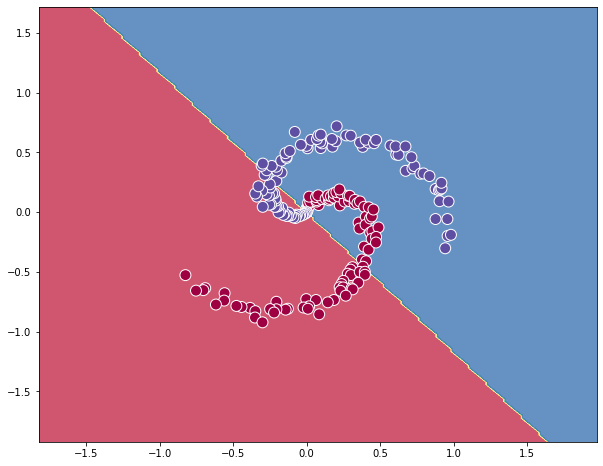

In [58]:
plot_classifier(X, y, W, b)

Now, as we have calculated the total error, we can proceed to minimizing it via gradient descent. We ought to calculate the gradient with respect to all changable weights in our simple model, namely **W** and **b**. Let's start by computing the gradient with respect to answers first.

Remind yourselves that `total_error = 1/2 * np.sum((truth - answers)**2)`, if we want to find `d(total_error)/d(answers)`. We will use `dTEdA` to denote this derivative.

We should be using **`dTE/dA`** notation as in the lecture slides, but since this is not a valid variable, we will use **`dTEdA`**.

In [0]:
##### YOUR CODE STARTS #####
dTEdA = answers - truth
dTEdA /= num_examples
##### YOUR CODE ENDS ##### (please do not delete this line)

Lastly, recall that `answers = np.dot(X, W) + b` (i.e. which is the same as to say `x*w +b` just in matrix notation) and calculate partial derivatives `d(answers)/d(weights)` and `d(answers)/d(biases)`, which will be denoted by `dAdW` and `dAdb` respectively.

In [0]:
##### YOUR CODE STARTS #####
dAdW = X
dAdb = 1
##### YOUR CODE ENDS ##### (please do not delete this line)

Recall the chain rule and use gradient on answers (stored in `dTEdA`), to calculate the gradient with respect to **`W`** and **`b`**. 

Here **`dW`** is actually **`dTEdW`**, but I used **`bW`** just to make it shorter.

Recall that **`dTE/dW = dTE/dA * dA/dW`**, same for biases, **`dTE/db = dTE/dA * dA/db`**

In [0]:
##### YOUR CODE STARTS #####
dW = np.dot(dAdW.T, dTEdA)
db = np.sum(dTEdA * dAdb, axis=0, keepdims=True)
##### YOUR CODE ENDS ##### (please do not delete this line)

In [62]:
print(f"Updates for W and b are {dW} and {db}")

Updates for W and b are [[-0.05335169 -0.06884455]
 [ 0.14864738 -0.13358175]] and [[-0.50001317 -0.49926073]]


Update old **`W`** and **`b`** using calculated **`dW`** and **`db`** (the update formula is in the lecture slides.

In [0]:
# perform a parameter update
step_size = 1

##### YOUR CODE STARTS #####
W = W - step_size*dW
b = b - step_size*db
##### YOUR CODE ENDS ##### (please do not delete this line)

New decision boundary now looks as follows:

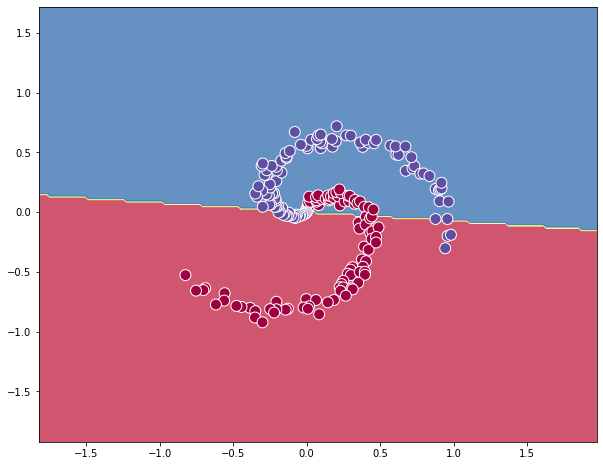

In [64]:
plot_classifier(X, y, W, b)

##Putting this all together: Training a linear classifier

In [65]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
step_size = 1

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):
  
  ##### YOUR CODE STARTS #####

  # evaluate answers, [N x K]
  answers = np.matmul(X, W) + b
  
  # compute the error: average sum of squared differences
  total_error = 1/2 * np.sum((truth - answers)**2)
  total_error = total_error/num_examples# we need to normalise the error over all examples, to keep things stable

  if i % 10 == 0:
    print("iteration %d: loss %e" % (i, total_error))
  
  # compute the gradient on answers
  dTEdA = answers - truth
  dTEdA /= num_examples

  # compute the gradient on weights and biases
  dAdW = X
  dAdb = 1

  # complete backpropatation path to the parameters (W,b)
  dW = np.dot(dAdW.T, dTEdA)
  db = np.sum(dTEdA * dAdb, axis=0, keepdims=True)
  
  # perform a parameter update
  W = W - step_size*dW
  b = b - step_size*db
  ##### YOUR CODE ENDS ##### (please do not delete this line)

iteration 0: loss 5.041981e-01
iteration 10: loss 1.406405e-01
iteration 20: loss 1.373883e-01
iteration 30: loss 1.371835e-01
iteration 40: loss 1.371670e-01
iteration 50: loss 1.371657e-01
iteration 60: loss 1.371655e-01
iteration 70: loss 1.371655e-01
iteration 80: loss 1.371655e-01
iteration 90: loss 1.371655e-01
iteration 100: loss 1.371655e-01
iteration 110: loss 1.371655e-01
iteration 120: loss 1.371655e-01
iteration 130: loss 1.371655e-01
iteration 140: loss 1.371655e-01
iteration 150: loss 1.371655e-01
iteration 160: loss 1.371655e-01
iteration 170: loss 1.371655e-01
iteration 180: loss 1.371655e-01
iteration 190: loss 1.371655e-01


In [66]:
# evaluate the final accuracy
answers = np.dot(X, W) + b
predicted_class = np.argmax(answers, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.77


This should produce something like **77%**. Not very good at all, but also not surprising given that the dataset is constructed so it is not linearly separable. We can also plot the learned decision boundaries. Btw, see if you can interpret this plot.

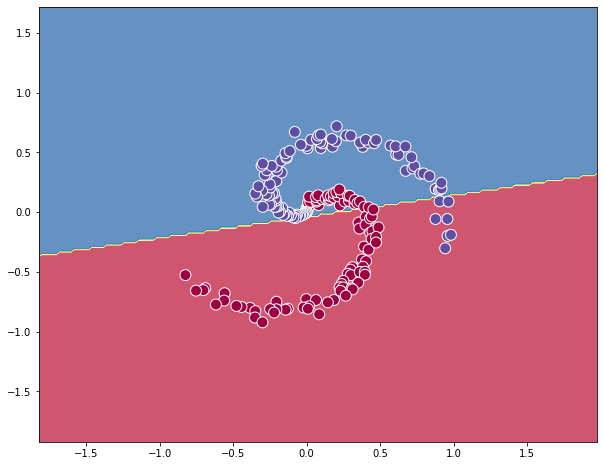

In [67]:
plot_classifier(X, y, W, b)

##Training a simple Neural Network

Clearly, two neurons are not enough for this dataset and we would like to use a **deeper neural network**. One additional hidden layer will suffice for this toy data. We will now need two sets of weights and biases (for the first and second layers):

In [0]:
# initialize parameters randomly
h = 100 # size of hidden layer

# first hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))

In [0]:
hiddel_layer = np.dot(X, W) + b
hidden_layer = np.maximum(0, hiddel_layer) # NB! ReLU activation

What are the dimensions of the second layer?

In [0]:
# initialize the second (output) layer
##### YOUR CODE STARTS #####
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))
##### YOUR CODE ENDS ##### (please do not delete this line)

Let's compute answers as before but now using a 2-layer (one hidden layer + one output layer) network:

In [0]:
answers = np.dot(hidden_layer, W2) + b2 # Note, no activation function for the second layer!

In [72]:
answers[0:5]

array([[ 0.00000000e+00,  0.00000000e+00],
       [-1.07898060e-05,  6.61038993e-06],
       [-2.58542394e-05,  1.33032428e-05],
       [-3.29467141e-05,  1.99829160e-05],
       [-5.08672026e-05,  2.64318602e-05]])

Note, we first compute the hidden layer representation and then the `answers` using output of the first layer and weights of the second layer. Crucially, we’ve also added a non-linearity, which in this case is simple ReLU that thresholds the activations in the hidden layer at zero.

Everything else remains the same. We compute the error based on the answers exactly as before, and get the gradient for the answers `dTEdA` exactly as before.

In [0]:
dTEdA = (truth - answers)*(-1)
dTEdA /= num_examples

However, the way we backpropagate that gradient into the model parameters now changes, of course. First lets backpropagate the second layer of the network.

In [0]:
# answers = np.dot(hidden_layer, W2) + b2
##### YOUR CODE STARTS #####
dAdW2 = hidden_layer
dAdb2 = 1
##### YOUR CODE ENDS ##### (please do not delete this line)

This looks identical to the code we had for the linear classifier, except we’re replacing `X` (the raw data), with the variable `hidden_layer`:

In [0]:
# first backprop to parameters W2 and b2
##### YOUR CODE STARTS #####
dW2 = np.dot(dAdW2.T, dTEdA)
db2 = np.sum(dTEdA * dAdb2, axis=0, keepdims=True)
##### YOUR CODE ENDS ##### (please do not delete this line)


However, unlike before we are not yet done, because **`hidden_layer`** is itself a function of other parameters and the data! We need to continue backpropagation through this variable. Remind yourself `answers = np.dot(hidden_layer, W2) + b2` and now find `dAdH`:



In [0]:
dAdH = W2.T
dH = np.dot(dTEdA, dAdH)

Now we have the gradient on the outputs of the hidden layer. Next, we have to backpropagate the ReLU non-linearity. This turns out to be easy because ReLU during the backward pass is effectively a switch. Since **`r = max(0,x)`**, we have that **`drdx = 1 (if x>0)`**. Therefore, ReLU unit lets the gradient pass through unchanged (multiplied by 1) if its input was greater than 0, but kills it if its input was less than zero during the forward pass. 


Complete code below to backpropagate the ReLU:

In [0]:
# backprop the ReLU non-linearity
##### YOUR CODE STARTS #####
dR = np.ones_like(np.dot(X, W) + b)
dR[np.dot(X, W) + b < 0] = 0
##### YOUR CODE ENDS ##### (please do not delete this line)

And now we finally continue to the first layer weights and biases the same way we did for linear classifier:

In [0]:
# finally into W,b
dW = np.dot(X.T, dH)
db = np.sum(dH, axis=0, keepdims=True)

The full code looks very similar to what we have written before:

In [79]:
# initialize parameters randomly
h = 100 # size of hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0

# gradient descent loop
num_examples = X.shape[0]
for i in range(2000):
  ##### YOUR CODE STARTS #####

  # evaluate answers, [N x K]
  hidden_layer = np.maximum(0, np.dot(X, W) + b) # note, ReLU activation
  answers = np.dot(hidden_layer, W2) + b2
  
  # compute the error: average sum of squared differences
  total_error = 1/2 * np.sum((truth - answers)**2) 
  total_error = total_error/num_examples

  if i % 100 == 0:
    print("iteration %d: loss %e" % (i, total_error))
  
  # compute the gradient on answers
  dTEdA = (truth - answers)*(-1)
  dTEdA /= num_examples
  
  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = np.dot(dAdW2.T, dTEdA)
  db2 = np.sum(dTEdA * dAdb2, axis=0, keepdims=True)
  
  # next backprop into hidden layer
  dAdH = W2.T
  dH = np.dot(dTEdA, dAdH)
  
  # backprop the ReLU non-linearity
  dH[hidden_layer <= 0] = 0

  # finally into W,b
  dW = np.dot(X.T, dH)
  db = np.sum(dH, axis=0, keepdims=True)
  
  # perform a parameter update
  W += - step_size*dW
  b += - step_size*db
  W2 += - step_size*dW2
  b2 += - step_size*db2

  ##### YOUR CODE ENDS ##### (please do not delete this line)

iteration 0: loss 5.002413e-01
iteration 100: loss 1.359291e-01
iteration 200: loss 1.301231e-01
iteration 300: loss 1.210134e-01
iteration 400: loss 1.075341e-01
iteration 500: loss 9.621193e-02
iteration 600: loss 8.653468e-02
iteration 700: loss 7.810435e-02
iteration 800: loss 7.342512e-02
iteration 900: loss 7.011517e-02
iteration 1000: loss 6.815560e-02
iteration 1100: loss 6.707383e-02
iteration 1200: loss 6.642582e-02
iteration 1300: loss 6.600695e-02
iteration 1400: loss 6.576065e-02
iteration 1500: loss 6.560490e-02
iteration 1600: loss 6.549805e-02
iteration 1700: loss 6.535078e-02
iteration 1800: loss 6.516216e-02
iteration 1900: loss 6.486565e-02


In [80]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
answers = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(answers, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.93


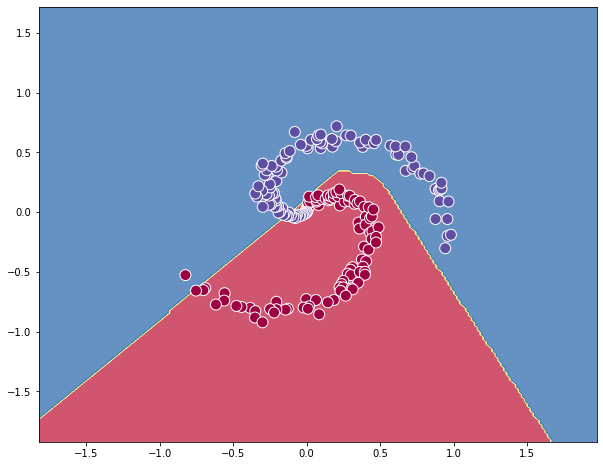

In [81]:
# plot the resulting classifier
plot_neural_network(X, y, W, b, W2, b2)

## Homework exercise 1 (8 points): three-layer network
<font color='red'> Obviously, 94% is not good enough for us, add one more layer to the network that we have defined before, by filling in the gaps.</font>

<font color='red'> **(a)** Initialise weights and compute the forward path with 2 hidden layers (each with `h` neurons and followed by the ReLu) and one output layer **(2 points)**. </font>

In [0]:
# initialize parameters randomly
h = 100 # size of hidden layer

# first hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))

# What should be the dimensions of the second layer?
##### YOUR CODE STARTS #####
W2 = 0.01 * np.random.randn(h,h)
b2 = np.zeros((1,h))
##### YOUR CODE ENDS ##### (please do not delete this line)

# the third layer for the class scores (second layer in previous network)
W3 = 0.01 * np.random.randn(h,K) 
b3 = np.zeros((1,K))

In [83]:
hidden_layer = np.maximum(0, np.dot(X, W) + b) # NB, ReLU activation
print(hidden_layer.shape)

(200, 100)


In [84]:
##### YOUR CODE STARTS #####
hidden_layer_2 = np.maximum(0, np.dot(hidden_layer, W2) + b2) # NB, ReLU activation
##### YOUR CODE ENDS ##### (please do not delete this line)
print(hidden_layer_2.shape)
print()

(200, 100)



In [85]:
answers = np.dot(hidden_layer_2, W3) + b3 # Note, no activation function for the second layer!
print(f'the shape of answers is {answers.shape}, and it should be (200, 2)')

the shape of answers is (200, 2), and it should be (200, 2)


Compute the total error as usuall

In [86]:
total_error = 1/2 * np.sum((truth - answers)**2) 
total_error = total_error/num_examples
print(np.round(total_error, 3))

0.5


<font color='red'> **(b)** Calculate `bW`, `db`, `bW2`, `db2`, `bW3` and `db3` usign backpropagation algorithm. **(3 points)** </font>

In [0]:
dTEdA = (truth - answers)*(-1)
dTEdA /= num_examples

In [0]:
# first backprop to parameters W3 and b3
##### YOUR CODE STARTS #####
dW3 = np.dot(hidden_layer_2.T, dTEdA)
db3 = np.sum(dTEdA * 1, axis=0, keepdims=True)
##### YOUR CODE ENDS ##### (please do not delete this line)

In [0]:
dH2 = np.dot(dTEdA, W3.T)
# ReLu in the second layer
dH2[hidden_layer_2 <= 0] = 0

In [0]:
# then backprop to parameters W2 and b2
##### YOUR CODE STARTS #####
dW2 = np.dot(hidden_layer.T, dH2)
db2 = np.sum(dH2, axis=0, keepdims=True)
##### YOUR CODE ENDS ##### (please do not delete this line)

In [0]:
dH = np.dot(dH2, W2.T)
# ReLu in the first layer
dH[hidden_layer <= 0] = 0

In [0]:
# finally into W,b
##### YOUR CODE STARTS #####
dW = np.dot(X.T, dH)
db = np.sum(dH, axis=0, keepdims=True)
##### YOUR CODE ENDS ##### (please do not delete this line)

<font color='red'> **(c)** Put together code from **(b)** into a single cell below and run the training **(1 point)** </font>

In [93]:
# initialize parameters randomly
h = 100 # size of hidden layer

# first hidden layer
W = 0.01 * np.random.randn(D,h)
b = np.zeros((1,h))

# What should be the dimensions of the second layer?
##### YOUR CODE STARTS #####
W2 = 0.01 * np.random.randn(h,h)
b2 = np.zeros((1,h))
##### YOUR CODE ENDS ##### (please do not delete this line)

# the third layer for the class scores (second layer in previous network)
W3 = 0.01 * np.random.randn(h,K) 
b3 = np.zeros((1,K))

# some hyperparameters
step_size = 1e-0

# gradient descent loop
num_examples = X.shape[0]
for i in range(2000):
  ##### YOUR CODE STARTS #####

  # forward path
  hidden_layer = np.maximum(0, np.dot(X, W) + b) 
  hidden_layer_2 = np.maximum(0, np.dot(hidden_layer, W2) + b2)
  answers = np.dot(hidden_layer_2, W3) + b3
  
  # compute the error: average sum of squared differences
  total_error = 1/2 * np.sum((truth - answers)**2) 
  total_error = total_error/num_examples

  if i % 100 == 0:
    print("iteration %d: loss %e" % (i, total_error))
  
  # compute the gradient on answers
  dTEdA = (truth - answers)*(-1)
  dTEdA /= num_examples
  
  # backpropate the gradient to the parameters

  # first backprop into parameters W3 and b3
  dW3 = np.dot(hidden_layer_2.T, dTEdA)
  db3 = np.sum(dTEdA * 1, axis=0, keepdims=True)
  
  dH2 = np.dot(dTEdA, W3.T)
  dH2[hidden_layer_2 <= 0] = 0

  # then backprop into W2 and b2
  dW2 = np.dot(hidden_layer.T, dH2)
  db2 = np.sum(dH2, axis=0, keepdims=True)

  dH = np.dot(dH2, W2.T)
  dH[hidden_layer <= 0] = 0

  # finally into W,b
  dW = np.dot(X.T, dH)
  db = np.sum(dH, axis=0, keepdims=True)
  
  # perform a parameter update
  W += - step_size * dW
  b += - step_size * db
  W2 += - step_size * dW2
  b2 += - step_size * db2
  W3 += - step_size * dW3
  b3 += - step_size * db3
  ##### YOUR CODE ENDS ##### (please do not delete this line)

iteration 0: loss 5.000037e-01
iteration 100: loss 1.674303e-01
iteration 200: loss 1.406958e-01
iteration 300: loss 1.361105e-01
iteration 400: loss 9.547308e-02
iteration 500: loss 6.104470e-02
iteration 600: loss 5.287913e-02
iteration 700: loss 4.953104e-02
iteration 800: loss 4.543001e-02
iteration 900: loss 3.995874e-02
iteration 1000: loss 3.577443e-02
iteration 1100: loss 3.364984e-02
iteration 1200: loss 3.094826e-02
iteration 1300: loss 2.955041e-02
iteration 1400: loss 2.791041e-02
iteration 1500: loss 2.641446e-02
iteration 1600: loss 2.578153e-02
iteration 1700: loss 2.411731e-02
iteration 1800: loss 2.276629e-02
iteration 1900: loss 2.194743e-02


In [94]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, np.dot(X, W) + b)
hidden_layer_2 = np.maximum(0, np.dot(hidden_layer, W2) + b2) # NB, ReLU activation
answers = np.dot(hidden_layer_2, W3) + b3 # Note, no activation function for the second layer!
predicted_class = np.argmax(answers, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y)))

training accuracy: 0.98


You should get about 98% of accuracy

<font color='red'> **(d)** Make a new function `plot_deep_neural_network` by altering the code of `plot_neural_network` to visualise obtained model with W, W2, W3 and b, b2, b3 **(1 point)** </font>



In [0]:
def plot_deep_neural_network(X, y, W, b ,W2, b2, W3, b3):
  h = 0.02
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
  
  ##### YOUR CODE STARTS #####
  Z = np.dot(np.maximum(0, np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2), W3) + b3
  ##### YOUR CODE ENDS ##### (please do not delete this line)
  
  Z = np.argmax(Z, axis=1)
  Z = Z.reshape(xx.shape)
  fig = plt.figure()
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=120, edgecolors = 'white', cmap=plt.cm.Spectral)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

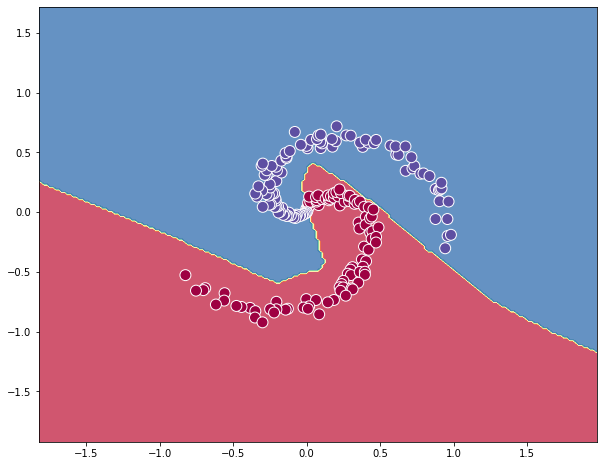

In [96]:
# plot the resulting classifier
plot_deep_neural_network(X, y, W, b, W2, b2, W3, b3)

<font color='red'> **(e)** Interpret obtained plot and accuracy. Did the classifier become more rigit or more flexible? Why? Did the perofrmance of the 3-layer network improve comparing to 2-layer network? **(1 point)** </font>


Answer to **(e)**: With 3-layer network we definetly get a better accuracy as of 98% (compared to 93% for network with 2 layers) and looking at the plot we could see that now model follows the data very precisely. So 3-layer network definetly much more flexible compared to 2-layer network and could  follow more complex patterns in data like with this spiral. It is possible since additional layer increase amount of network parameters to train and as result model has more degrees of freedom to fit data more closely. Smaller network on opposite has less parameters to train and as result could not follow complex patterns in data - it lack of computational capabilities to closely follow the data. However, it is important to note that with increasing amount of layers models become more prone to overfitting. Thus, regardless how many layers network has, we should carefully assess if it does not overfit to training data, since then it loose its flexibility and will work well only with specific training data and will faile to generalize well on unknown data. If network is overfitting, one of possible option to reduce an overfit could be simplication of network architecture (removing or replace some layers with more simple one). In a nutshell, it is hard to say that in general n+1-layer network is more flexible than n-layer network, because it could be really specific to particular data and use case. To properly asses it, we need to exclude that n+1-layer network overfitting to data, otherwise its flexibility will become its curse. 

Speaking about execution time - 3-layer network will be slower than 2-layer network because of increasing number of back-propagation steps. Forward propagation steps are not that performance intensive and another step should not cause noticable difference, but backward propagation steps are intensive and another step will cause noticable difference.

##Using Keras
Of course there is an elephant in the room. Nobody uses pure Python to implement Neural Networks these days. So let's see how the same very simple 2-layer architecture is designed in Keras with way fewer lines of code. 

[Keras](https://keras.io/) is a high-level neural networks constructor, written on top of TensorFlow. Keras has very well designed API, which allows for concise code and flexibility at the same time.

In [97]:
%tensorflow_version 1.x
from keras.models import Sequential
from keras.layers import Dense

TensorFlow 1.x selected.


Using TensorFlow backend.


Here is how you build a 2-layer neural network with 100 neurons in the hiddel layer in Keras:

In [98]:
h = 100

model = Sequential() # let's us define the network layer by layer
model.add(Dense(h, input_dim=2, activation='relu')) # hidden layer
model.add(Dense(K, activation='sigmoid')) # as many neurons as there are classes

In [99]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [100]:
# Run the model
history = model.fit(X, truth, epochs=150, batch_size=10)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/150





200/200 [==============================] - 9s 44ms/step - loss: 0.6819 - acc: 0.6300
Epoch 2/150
200/200 [==============================] - 0s 371us/step - loss: 0.6519 - acc: 0.7800
Epoch 3/150
200/200 [==============================] - 0s 403us/step - loss: 0.6184 - acc: 0.8000
Epoch 4/150
200/200 [==============================] - 0s 353us/step - loss: 0.5865 - acc: 0.7900
Epoch 5/150
200/200 [==============================] - 0s 368us/step - loss: 0.5504 - acc: 0.7900
Epoch 6/150
200/200 [==============================] - 0s 274us/step - loss: 0.5146 - acc: 0.7600
Epoch 7/150
200/200 [==============================] - 0s 303us/step - loss: 0.4812 - acc: 0.7650
Epoch 8/150
200/200 [==============================] - 0s 311us/step - loss: 0.4503 - acc: 0.7600
Epoch 9/150
200/200 [==============================] - 0s 289us/step - loss: 0.4257 - acc: 0.7600
Epoch 10/150
200/

In [101]:
# evaluate the model
scores = model.evaluate(X, truth)
print(f"Accuracy is {scores[1]*100}%")

200/200 [==============================] - 0s 205us/step
Accuracy is 98.5%


(-1.921662395679324, 1.7183376043206793)

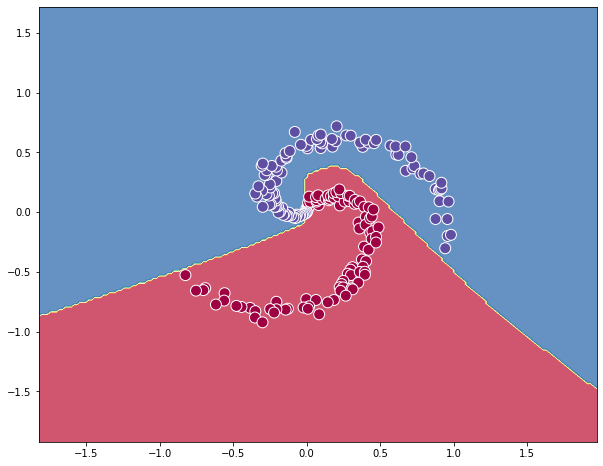

In [102]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=120, edgecolors = 'white', cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

As we kept records of the learning process in the `history` variable, we now can visualise the dynamics of the training process by plotting loss at different epochs:

Text(0.5, 1.0, 'Loss')

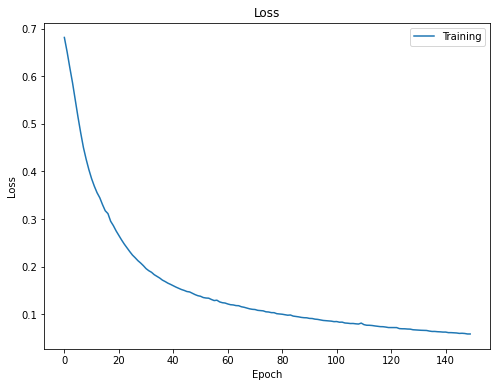

In [103]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training'])
plt.title('Loss')

# Convolutional Neural Networks
## Keras on CIFAR10

In this part of the class, we will examine convolutional neural networks (CNN). As CNNs were designed specifically to work with imaging data,  we will use CIFAR-10 dataset to demonstrate their effectiveness on images. The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consists of 60 000 pictures divided into 10 classes (hence the name CIFAR-10). Classes include common objects such as airplanes, automobiles, birds, cats and so on. Our goal is to train a convolutional neural network to classify these images.

The following instructions help to install required dependencies and load the data.

In [104]:
# A bit of setup again
import numpy as np
import matplotlib.pyplot as plt

# loading in the cifar10 dataset
from keras.datasets import cifar10

# Keras comes with built-in loaders for common datasets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# shorten dataset for quicker training
X_train = X_train[:25000]
y_train = y_train[:25000]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

170500096/170498071 [==============================] - 13s 0us/step
Train data shape:  (25000, 32, 32, 3)
Train labels shape:  (25000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


Let's visualise several random images from each class to get familiar with the data:

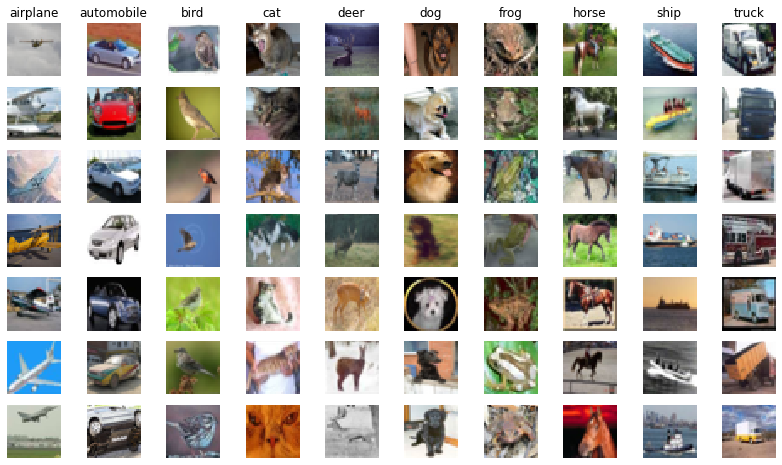

In [105]:
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
# "Names" of classes:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
num_classes = len(class_names)

samples_per_class = 7 # Number of images from each class we want to see
for y, cls in enumerate(class_names):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((32, 32, 3)), plt.get_cmap('gray'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

Do all images look right? Is there anything unexpected?

Building an effective neural network model requires careful consideration of the network architecture as well as the input data format. What do the 4 dimensions ((50000, 32, 32, 3)) of X_train represent? What values do these data contain and from what range do these values come from?

**Data normalisation step.** Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. Data normalization is done by subtracting the mean from each pixel and then dividing the result by the standard deviation [[source](https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258)]. In our case we do it for each RGB component separately.

In [0]:
mu = X_train.mean(axis=(0,1,2)) # finds mean of R, G and B separately
std = X_train.std(axis=(0,1,2)) # same for std
X_train_norm = (X_train - mu)/std
X_test_norm = (X_test - mu)/std

Now we are ready to define our Convolutional Neural Network model. First we need to specify the layers that we will be using.

Here is the architecture that we shall use:

1. 3x3 convolution with 32 filters, stride 1, padding same
2. batch normalization
3. relu
4. 3x3 convolution with 32 filters, stride 1, padding valid
5. batch normalization
6. relu
7. max pooling 2x2
8. dropout 0.25
7. flatten
8. dense 100
5. batch normalization
6. relu
8. dropout 0.5
8. dense 10
9. softmax

You can consult Keras documentation for layer parameters:
 - [Convolutional layers](https://keras.io/layers/convolutional/)
 - [Pooling layers](https://keras.io/layers/pooling/)
 - [Normalization layers](https://keras.io/layers/normalization/)

Here is how aforementioned architecture can be implemented in Keras. Note the difference in notation with network we defined earlier: here we explicitely specify input and output of each layer.

In [107]:
from keras.layers import Input, Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

x = Input(shape=(32, 32, 3))
c1 = Conv2D(32, (3, 3), strides=(1, 1), padding="same")(x)
b1 = BatchNormalization()(c1)
a1 = Activation('relu')(b1)
c2 = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(a1)
b2 = BatchNormalization()(c2)
a2 = Activation('relu')(b2)
p2 = MaxPooling2D(pool_size=2)(a2)
d2 = Dropout(rate=0.25)(p2)
f2 = Flatten()(d2) # tensor into vector
h3 = Dense(100)(f2)
b3 = BatchNormalization()(h3)
a3 = Activation('relu')(b3)
d3 = Dropout(rate=0.5)(a3)
z = Dense(10)(d3)
p = Activation('softmax')(z)




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Describe shortly what are Conv2D, BatchNormalization, Dropout and Dense? 

Now that we have defined the arhitecture, we can create a model simply by saying what is the input and what is output. Cross-entropy loss is applied to the network with Adam optimizer and additional accuracy metric.
**`sparse_categorical_crossentropy`** loss allows us to pass integer class values directly as targets and is potentially more efficient than categorical_crossentropy, which needs one-hot vectors as targets.

`model.summary()` prints out layer list with output shapes and is very useful for debugging the model. 

In [108]:
from keras.models import Model
from keras.optimizers import Adam

model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0   

Let's train this convolutional neural network on CIFAR10, `validation_split` defines the number of data rows that will be used for validation. 

In [109]:
# Fit the model; returns History object
history = model.fit(X_train_norm, y_train, batch_size=64, epochs=20, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/20
22500/22500 [==============================] - 10s 437us/step - loss: 1.6844 - acc: 0.4089 - val_loss: 1.2339 - val_acc: 0.5612
Epoch 2/20
22500/22500 [==============================] - 4s 162us/step - loss: 1.2755 - acc: 0.5457 - val_loss: 1.0949 - val_acc: 0.6148
Epoch 3/20
22500/22500 [==============================] - 4s 163us/step - loss: 1.1209 - acc: 0.6054 - val_loss: 1.0140 - val_acc: 0.6488
Epoch 4/20
22500/22500 [==============================] - 4s 164us/step - loss: 1.0212 - acc: 0.6404 - val_loss: 1.0661 - val_acc: 0.6372
Epoch 5/20
22500/22500 [==============================] - 4s 162us/step - loss: 0.9613 - acc: 0.6588 - val_loss: 0.9634 - val_acc: 0.6600
Epoch 6/20
22500/22500 [==============================] - 4s 164us/step - loss: 0.8990 - acc: 0.6848 - val_loss: 0.9447 - val_acc: 0.6632
Epoch 7/20
22500/22500 [==============================] - 4s 160us/step - loss: 0.8494 - acc: 0.7005 - val_loss: 0.9692 - 

What do concepts such as **batch** and **epoch** stand for?

The following graphs illustrate the behaviour of Loss and Accuracy during the training process.

Text(0.5, 1.0, 'Accuracy')

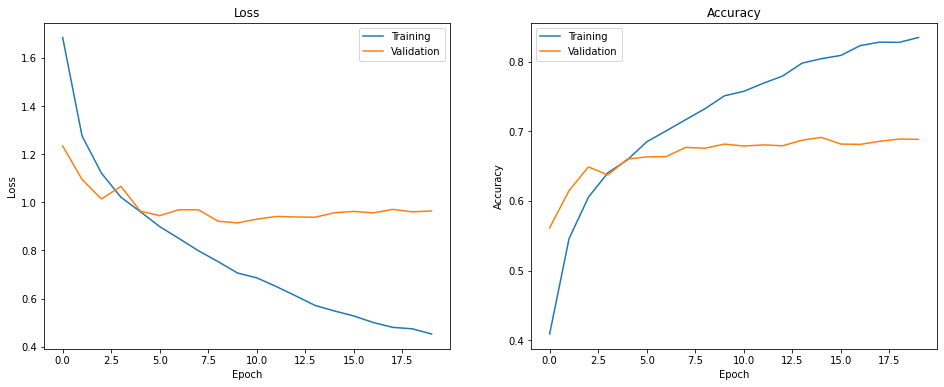

In [110]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

Next we will evaluate our trained network on the test and training data.

In [111]:
# IPython notebook just prints out the returned values - loss and accuracy
model.evaluate(X_test_norm, y_test)

10000/10000 [==============================] - 1s 109us/step


[1.0008477569580079, 0.679]

In [112]:
# the same for training set
model.evaluate(X_train_norm, y_train)

25000/25000 [==============================] - 3s 102us/step


[0.24720431310653687, 0.94224]

Based on the training and test accuracy, is the trained network good?

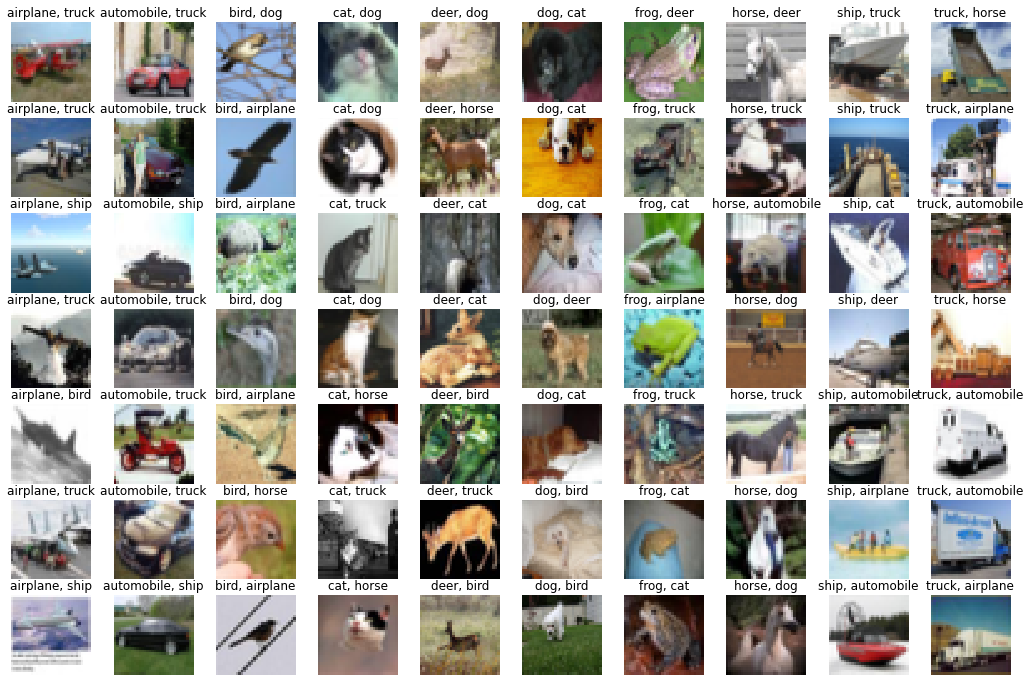

In [113]:
test_predicted = np.argmax(model.predict(X_test_norm), axis=1)

plt.rcParams['figure.figsize'] = (18.0, 12.0) # set default size of plots
# "Names" of classes:
classes = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
num_classes = len(classes)
samples_per_class = 7 # Number of images from each class we want to see
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_test == y)   

    misclas_idxs = np.flatnonzero(np.array(test_predicted)[idxs] != y)

    if samples_per_class < len(misclas_idxs):
      misclas_idxs = np.random.choice(misclas_idxs, samples_per_class, replace=False)
    
    for i, idx in enumerate(misclas_idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_test[idxs[idx]].reshape((32, 32, 3)), plt.get_cmap('gray'))
        plt.axis('off')
        plt.title(str(classes[y]) + ", " + str(classes[np.array(test_predicted)[idxs[idx]]]))
plt.show()

## Homework exercise 2 (3 points): adding and subtracting layers in Keras
<font color='red'> Sometimes you may want to experiment with the number of layers in your network. Adding or subtracting layers is one of the simplest ways to reduce overfitting or improve the performance of your model. Here we will practice adding and remove layers in Keras (feel the difference with pure Python). </font>

<font color='red'> **(a)** Copy paste to cell below the initial CNN model created for CIFAR10. Next, remove the second Conv2D + BatchNorm + ReLu block and train this smaller network on the same data (make sure to correctly link the layers in the model). Visualise the learning curves. **(1 point)** </font>

In [0]:
##### YOUR CODE STARTS #####
x = Input(shape=(32, 32, 3))
c1 = Conv2D(32, (3, 3), strides=(1, 1), padding="same")(x)
b1 = BatchNormalization()(c1)
a1 = Activation('relu')(b1)
p2 = MaxPooling2D(pool_size=2)(a1)
d2 = Dropout(rate=0.25)(p2)
f2 = Flatten()(d2) # tensor into vector
h3 = Dense(100)(f2)
b3 = BatchNormalization()(h3)
a3 = Activation('relu')(b3)
d3 = Dropout(rate=0.5)(a3)
z = Dense(10)(d3)
p = Activation('softmax')(z)
##### YOUR CODE ENDS ##### (please do not delete this line)

In [116]:
smaller_model = Model(inputs=x, outputs=p)
smaller_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
smaller_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0   

In [117]:
# Fit the model; returns History object
history_smaller = smaller_model.fit(X_train_norm, y_train, batch_size=64, epochs=20, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/20
22500/22500 [==============================] - 4s 168us/step - loss: 1.7408 - acc: 0.3955 - val_loss: 1.3089 - val_acc: 0.5328
Epoch 2/20
22500/22500 [==============================] - 3s 130us/step - loss: 1.3766 - acc: 0.5067 - val_loss: 1.1960 - val_acc: 0.5708
Epoch 3/20
22500/22500 [==============================] - 3s 131us/step - loss: 1.2526 - acc: 0.5546 - val_loss: 1.1370 - val_acc: 0.6032
Epoch 4/20
22500/22500 [==============================] - 3s 134us/step - loss: 1.1771 - acc: 0.5848 - val_loss: 1.0872 - val_acc: 0.6096
Epoch 5/20
22500/22500 [==============================] - 3s 133us/step - loss: 1.1086 - acc: 0.6086 - val_loss: 1.0758 - val_acc: 0.6104
Epoch 6/20
22500/22500 [==============================] - 3s 134us/step - loss: 1.0610 - acc: 0.6220 - val_loss: 1.0394 - val_acc: 0.6300
Epoch 7/20
22500/22500 [==============================] - 3s 134us/step - loss: 1.0099 - acc: 0.6400 - val_loss: 1.0554 - v

Text(0.5, 1.0, 'Accuracy')

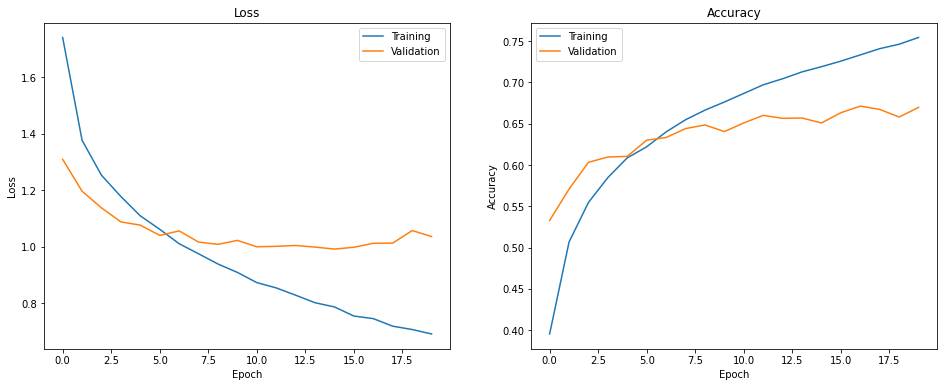

In [118]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history_smaller.history['loss'])
plt.plot(history_smaller.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_smaller.history['acc'])
plt.plot(history_smaller.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

<font color='red'> **(b)** Now make a bigger version of the same network, by adding additional Conv2D + BatchNorm + ReLu block. So you should have three Conv2D + BatchNorm + ReLu blocks now. Next train it and visualise learning curves **(1 point)**. </font>

In [0]:
##### YOUR CODE STARTS #####
x = Input(shape=(32, 32, 3))
c1 = Conv2D(32, (3, 3), strides=(1, 1), padding="same")(x)
b1 = BatchNormalization()(c1)
a1 = Activation('relu')(b1)
c2 = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(a1)
b2 = BatchNormalization()(c2)
a2 = Activation('relu')(b2)
c3 = Conv2D(32, (3, 3), strides=(1, 1), padding="valid")(a2)
b3 = BatchNormalization()(c3)
a3 = Activation('relu')(b3)
p2 = MaxPooling2D(pool_size=2)(a3)
d2 = Dropout(rate=0.25)(p2)
f2 = Flatten()(d2) # tensor into vector
h3 = Dense(100)(f2)
b3 = BatchNormalization()(h3)
a3 = Activation('relu')(b3)
d3 = Dropout(rate=0.5)(a3)
z = Dense(10)(d3)
p = Activation('softmax')(z)
##### YOUR CODE ENDS ##### (please do not delete this line)

In [120]:
bigger_model = Model(inputs=x, outputs=p)
bigger_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
bigger_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
activation_12 (Activation)   (None, 30, 30, 32)        0   

In [121]:
# Fit the model; returns History object
history_bigger = bigger_model.fit(X_train_norm, y_train, batch_size=64, epochs=20, validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/20
22500/22500 [==============================] - 6s 251us/step - loss: 1.6333 - acc: 0.4243 - val_loss: 1.3427 - val_acc: 0.5056
Epoch 2/20
22500/22500 [==============================] - 4s 196us/step - loss: 1.2288 - acc: 0.5628 - val_loss: 1.0947 - val_acc: 0.6116
Epoch 3/20
22500/22500 [==============================] - 4s 190us/step - loss: 1.0798 - acc: 0.6191 - val_loss: 1.0489 - val_acc: 0.6236
Epoch 4/20
22500/22500 [==============================] - 4s 190us/step - loss: 0.9779 - acc: 0.6568 - val_loss: 0.9850 - val_acc: 0.6564
Epoch 5/20
22500/22500 [==============================] - 4s 191us/step - loss: 0.9130 - acc: 0.6746 - val_loss: 0.9104 - val_acc: 0.6732
Epoch 6/20
22500/22500 [==============================] - 4s 190us/step - loss: 0.8489 - acc: 0.6995 - val_loss: 0.9161 - val_acc: 0.6812
Epoch 7/20
22500/22500 [==============================] - 4s 193us/step - loss: 0.8039 - acc: 0.7149 - val_loss: 0.9455 - v

Text(0.5, 1.0, 'Accuracy')

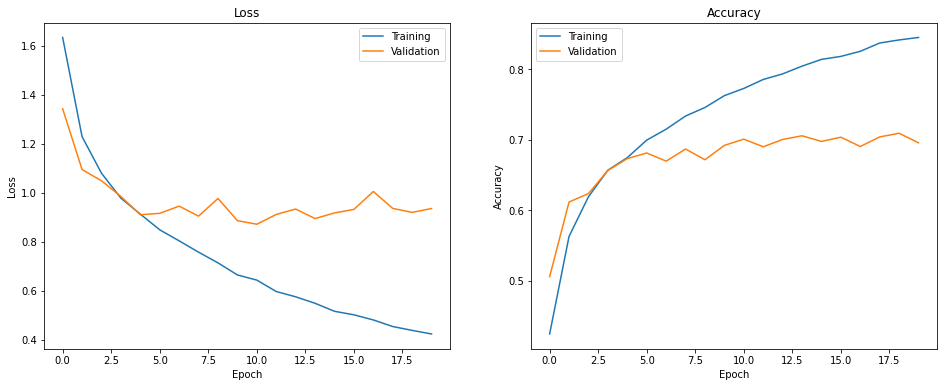

In [122]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history_bigger.history['loss'])
plt.plot(history_bigger.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history_bigger.history['acc'])
plt.plot(history_bigger.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

<font color='red'> **(c)** Compare learning curves for smaller and bigger versions and say which version has overfitted the data more significantly? Why do you think so? Which network you would run in production? **(1 point)**. </font>

Answer to **(c)**: Based on produced plots I could conclude that bigger network overfits more to data compare to smaller one. Such conclusion derived from delta between training and validation loss\accuracy lines. For smaller network loss delta is around 0.3, while for bigger network it is around 0.6. This indicates that bigger network potentially overfits to training data. Same with accuracy - for smaller network delta is around 0.1, while for bigger one it is around 0.15. 

Despite biger network has slightly higher accuracy on validation set, I would recommend to use smaller network for production deployment. From my perspective it will generalize better to unknown data compare to bigger model, which is prone to overfitting.

## CNN on MNIST
Let's use one of the convolutional neural networks we defined above to classify MNIST.

In [123]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

X_train = np.reshape(mnist.train.images, (55000, 28, 28, 1))
y_train = np.reshape(mnist.train.labels, (55000, 1))
print(f"Train images are of shape: {X_train.shape} and labels: {y_train.shape}")

X_test = np.reshape(mnist.test.images, (10000, 28, 28, 1))
y_test = np.reshape(mnist.test.labels, (10000, 1))
print(f"Test images are of shape: {X_test.shape} and labels: {y_test.shape}")

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Train images are of shape: (55000, 28, 

Copy and paste below one of the convolutional neural networks we have defined previously.


NB! Make sure the input shape is correct (recall that MNIST is 28x28x1 not 32x32x3 as CIFAR10).

In [0]:
##### YOUR CODE STARTS #####
x = Input(shape=(28, 28, 1))
c1 = Conv2D(28, (3, 3), strides=(1, 1), padding="same")(x)
b1 = BatchNormalization()(c1)
a1 = Activation('relu')(b1)
p2 = MaxPooling2D(pool_size=2)(a1)
d2 = Dropout(rate=0.25)(p2)
f2 = Flatten()(d2) # tensor into vector
h3 = Dense(100)(f2)
b3 = BatchNormalization()(h3)
a3 = Activation('relu')(b3)
d3 = Dropout(rate=0.5)(a3)
z = Dense(10)(d3)
p = Activation('softmax')(z)
##### YOUR CODE ENDS ##### (please do not delete this line)

Compile and train your model, keep the record of loss in the `history` variable.

In [125]:
##### YOUR CODE STARTS #####
model = Model(inputs=x, outputs=p)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.1)
##### YOUR CODE ENDS ##### (please do not delete this line)

Train on 49500 samples, validate on 5500 samples
Epoch 1/10
49500/49500 [==============================] - 6s 123us/step - loss: 0.2782 - acc: 0.9206 - val_loss: 0.0714 - val_acc: 0.9804
Epoch 2/10
49500/49500 [==============================] - 5s 100us/step - loss: 0.1329 - acc: 0.9607 - val_loss: 0.0560 - val_acc: 0.9847
Epoch 3/10
49500/49500 [==============================] - 5s 99us/step - loss: 0.1039 - acc: 0.9692 - val_loss: 0.0499 - val_acc: 0.9853
Epoch 4/10
49500/49500 [==============================] - 5s 102us/step - loss: 0.0900 - acc: 0.9726 - val_loss: 0.0476 - val_acc: 0.9862
Epoch 5/10
49500/49500 [==============================] - 5s 100us/step - loss: 0.0802 - acc: 0.9743 - val_loss: 0.0614 - val_acc: 0.9825
Epoch 6/10
49500/49500 [==============================] - 5s 100us/step - loss: 0.0721 - acc: 0.9766 - val_loss: 0.0403 - val_acc: 0.9887
Epoch 7/10
49500/49500 [==============================] - 5s 97us/step - loss: 0.0660 - acc: 0.9791 - val_loss: 0.0561 - val

Visualise the training and validation accuracy and loss dynamics over epochs.

Text(0.5, 1.0, 'Accuracy')

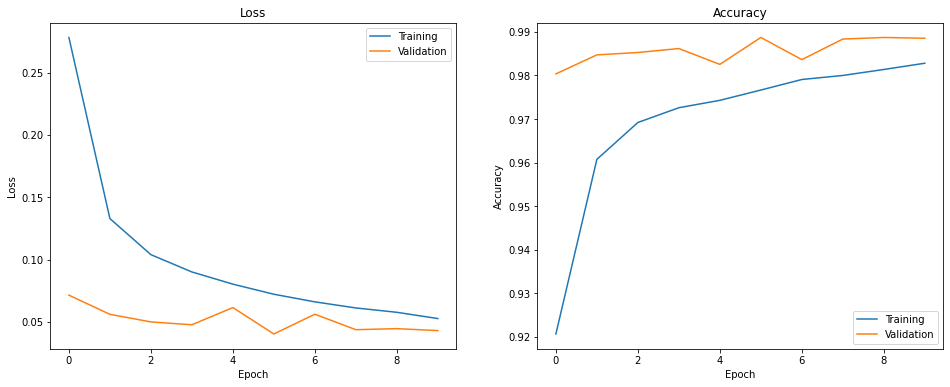

In [127]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validation'])
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')

Does our network overfit? Does it have enough power to solve the problem?

Evaluate model on test images

In [128]:
# IPython notebook just prints out the returned values - loss and accuracy
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 64us/step


[0.03942522027051018, 0.9883]

Here we visualise misclassified examples for CNN on MNIST dataset: 

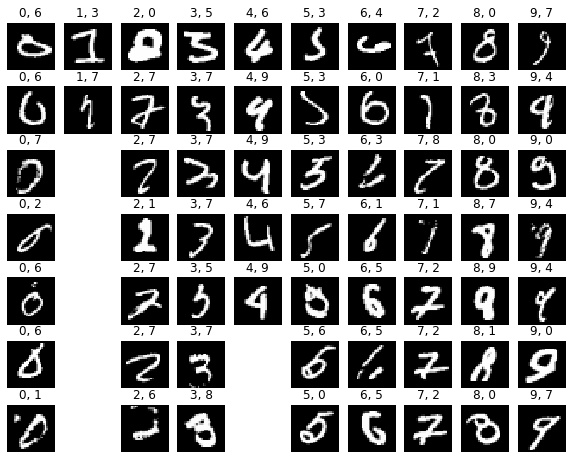

In [129]:
test_predicted = np.argmax(model.predict(X_test), axis=1)

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
# "Names" of classes:
classes =  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

num_classes = len(classes)
samples_per_class = 7 # Number of images from each class we want to see
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_test == y)   

    misclas_idxs = np.flatnonzero(np.array(test_predicted)[idxs] != y)

    if samples_per_class < len(misclas_idxs):
      misclas_idxs = np.random.choice(misclas_idxs, samples_per_class, replace=False)
    
    for i, idx in enumerate(misclas_idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_test[idxs[idx]].reshape((28, 28)), plt.get_cmap('gray'))
        plt.axis('off')
        plt.title(str(y) + ", " + str(np.array(test_predicted)[idxs[idx]]))
plt.show()

Do misclassifications look reasonable? 

# Fast.ai library

What is [fast.ai](https://docs.fast.ai/)?

Basically fast.ai is Keras on top of Pytorch that uses cutting edge research in Deep Learning.

**Why to introduce yet another library for DL in this class?**
* want to mention fast.ai online course which is great (it does not require you to use fast.ai library)
* image scraping exercise in the end of this class 
* fast.ai are usually the first to implement SOTA techniques (e.g. learning rate finder), and thus thier library usually provides cutting edge results in many domains

**Bad things about fast.ai (why my team don't use fast.ai):**
* if you want to change something or apply fast.ai in a custom way to custom data, the chances are high - it is going to be painful, why? ->
* the documentation is really bad, unless you are Jeremy Howard who has written it

## fast.ai on CIFAR10

In [130]:
from fastai.vision import *
from fastai.metrics import error_rate

path = untar_data(URLs.CIFAR); path #it says just CIFAR, but since there is CIFAR_100, I hope that this is CIFAR10
data = ImageDataBunch.from_folder(path, valid_pct = 0.1, size=48)
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [131]:
learn.fit_one_cycle(3)

## fast.ai on MNIST

In [132]:
path = untar_data(URLs.MNIST); path
data = ImageDataBunch.from_folder(path, valid_pct=.1, size=48)
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [133]:
learn.fit_one_cycle(3)

## Creating your own dataset using fast.ai
*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In this tutorial we will see how to easily create an image dataset through Google Images. **Note**: You will have to repeat these steps for any new category you want to Google (e.g once for dogs and once for cats).

### Get a list of URLs

Go to [Google Images](http://images.google.com) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

    "canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.

### Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

In Google Chrome press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>j</kbd> on Windows/Linux and <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>j</kbd> on macOS, and a small window the javascript 'Console' will appear. In Firefox press <kbd>Ctrl</kbd><kbd>Shift</kbd><kbd>k</kbd> on Windows/Linux or <kbd>Cmd</kbd><kbd>Opt</kbd><kbd>k</kbd> on macOS. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```javascript
urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```

After both files are downloaded and renamed, upload them to colab by running the following command

In [0]:
from google.colab import files
uploaded = files.upload()

Saving leopard.csv to leopard.csv


In [0]:
!ls

leopard.csv  sample_data


In [0]:
from google.colab import files
uploaded = files.upload()

Saving jaguar.csv to jaguar.csv


In [0]:
!ls

jaguar.csv  leopard.csv  sample_data


### Create directory and upload urls file into your server
Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.

In [0]:
folder = 'leopards'
file = 'leopards.csv'

In [0]:
path = Path('data/cats')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [0]:
folder = 'jaguars'
file = 'jaguars.csv'

In [0]:
path = Path('data/cats')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [0]:
path.ls()

[PosixPath('data/cats/jaguars'), PosixPath('data/cats/leopards')]

## Download images
Now you will need to download your images from their respective urls.

fast.ai has a function that allows you to do just that. You just have to specify the urls filename as well as the destination folder and this function will download and save all images that can be opened. If they have some problem in being opened, they will not be saved.

Let's download our images! Notice you can choose a maximum number of images to be downloaded. In this case we will not download all the urls.

In [0]:
folder = 'leopards'
dest = path/folder
download_images('leopards.csv', dest, max_pics=400)

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

In [0]:
folder = 'jaguars'
dest = path/folder
download_images('jaguars.csv', dest, max_pics=400)

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

In [0]:
classes = ['leopards','jaguars']

Then we can remove any images that can't be opened:

In [0]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

leopards


jaguars


## View data

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes

['jaguars', 'leopards']

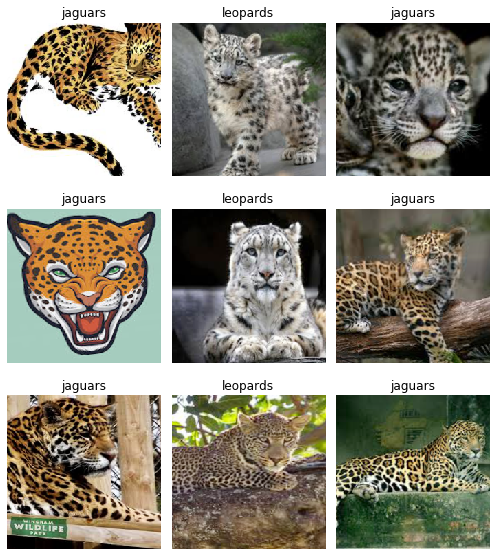

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['jaguars', 'leopards'], 2, 512, 128)

## Train model

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [0]:
learn.fit_one_cycle(5)

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

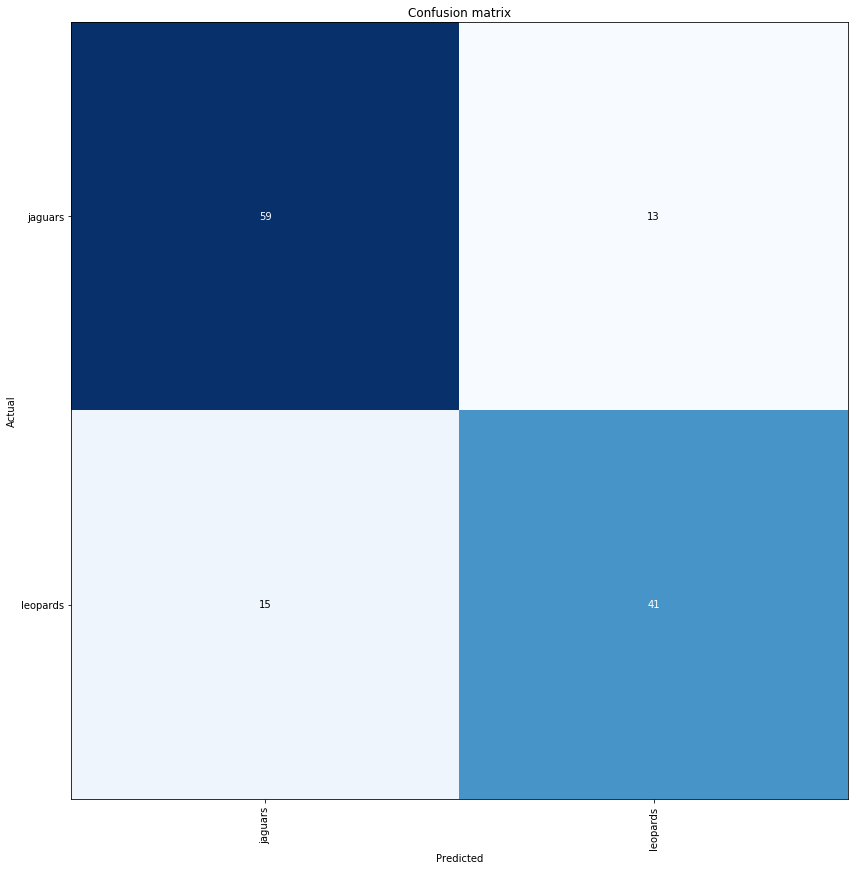

In [0]:
interp.plot_confusion_matrix()

In [0]:
!ls $path/'leopards'/

00000000.jpg  00000064.jpg  00000148.jpg  00000232.jpg	00000316.jpg
00000001.jpg  00000065.jpg  00000149.jpg  00000233.jpg	00000317.jpg
00000002.jpg  00000066.jpg  00000150.jpg  00000234.jpg	00000318.jpg
00000003.jpg  00000067.jpg  00000151.jpg  00000235.jpg	00000319.jpg
00000004.jpg  00000068.jpg  00000152.jpg  00000236.jpg	00000320.jpg
00000005.jpg  00000069.jpg  00000153.jpg  00000237.jpg	00000321.jpg
00000006.jpg  00000070.jpg  00000154.jpg  00000238.jpg	00000322.jpg
00000007.jpg  00000071.jpg  00000155.jpg  00000239.jpg	00000323.jpg
00000008.jpg  00000072.jpg  00000156.jpg  00000240.jpg	00000324.jpg
00000009.jpg  00000073.jpg  00000157.jpg  00000241.jpg	00000325.jpg
00000010.jpg  00000074.jpg  00000158.jpg  00000242.jpg	00000326.jpg
00000011.jpg  00000075.jpg  00000159.jpg  00000243.jpg	00000327.jpg
00000012.jpg  00000076.jpg  00000160.jpg  00000244.jpg	00000328.jpg
00000013.jpg  00000077.jpg  00000161.jpg  00000245.jpg	00000329.jpg
00000014.jpg  00000078.jpg  00000162.jpg  000002

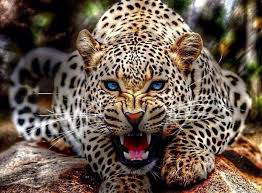

In [0]:
img = open_image(path/'leopards'/'00000010.jpg')
img

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category leopards

Get a url on the jaguar image from internet and insert it below

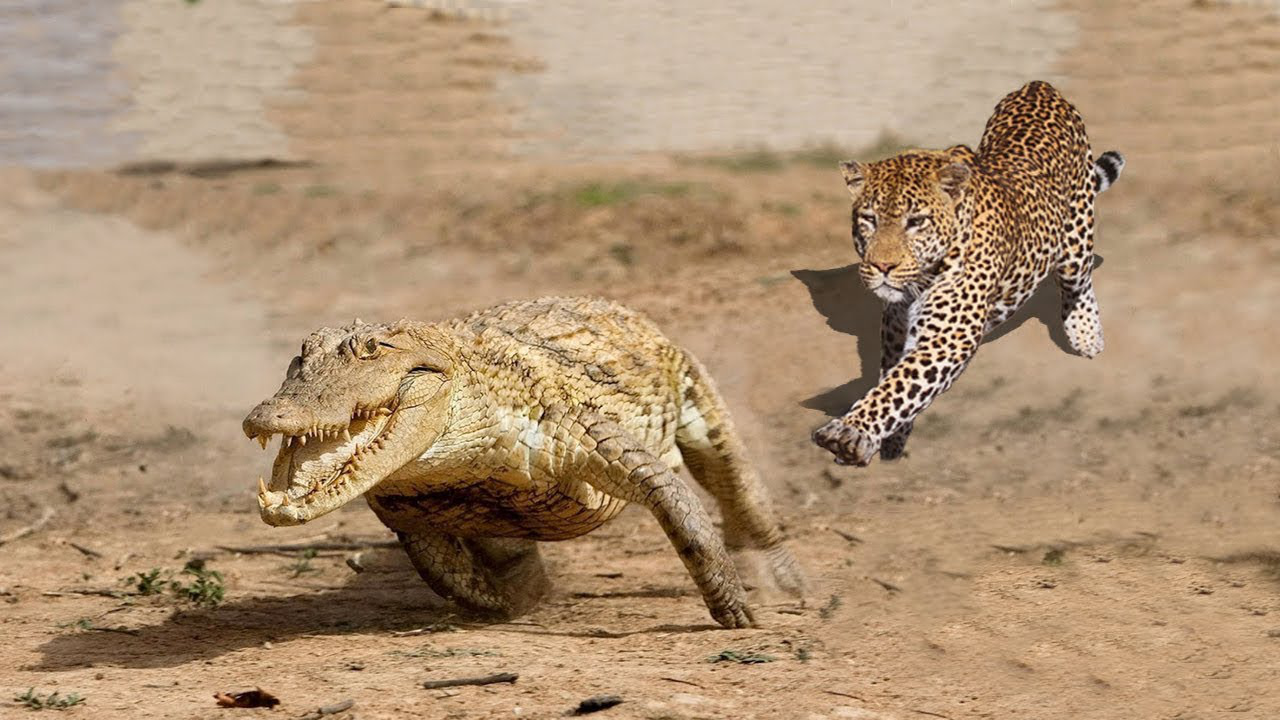

In [0]:
from urllib.request import urlopen

img = open_image(urlopen('https://i.ytimg.com/vi/0-izEXLJ39w/maxresdefault.jpg'))
img

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category leopards

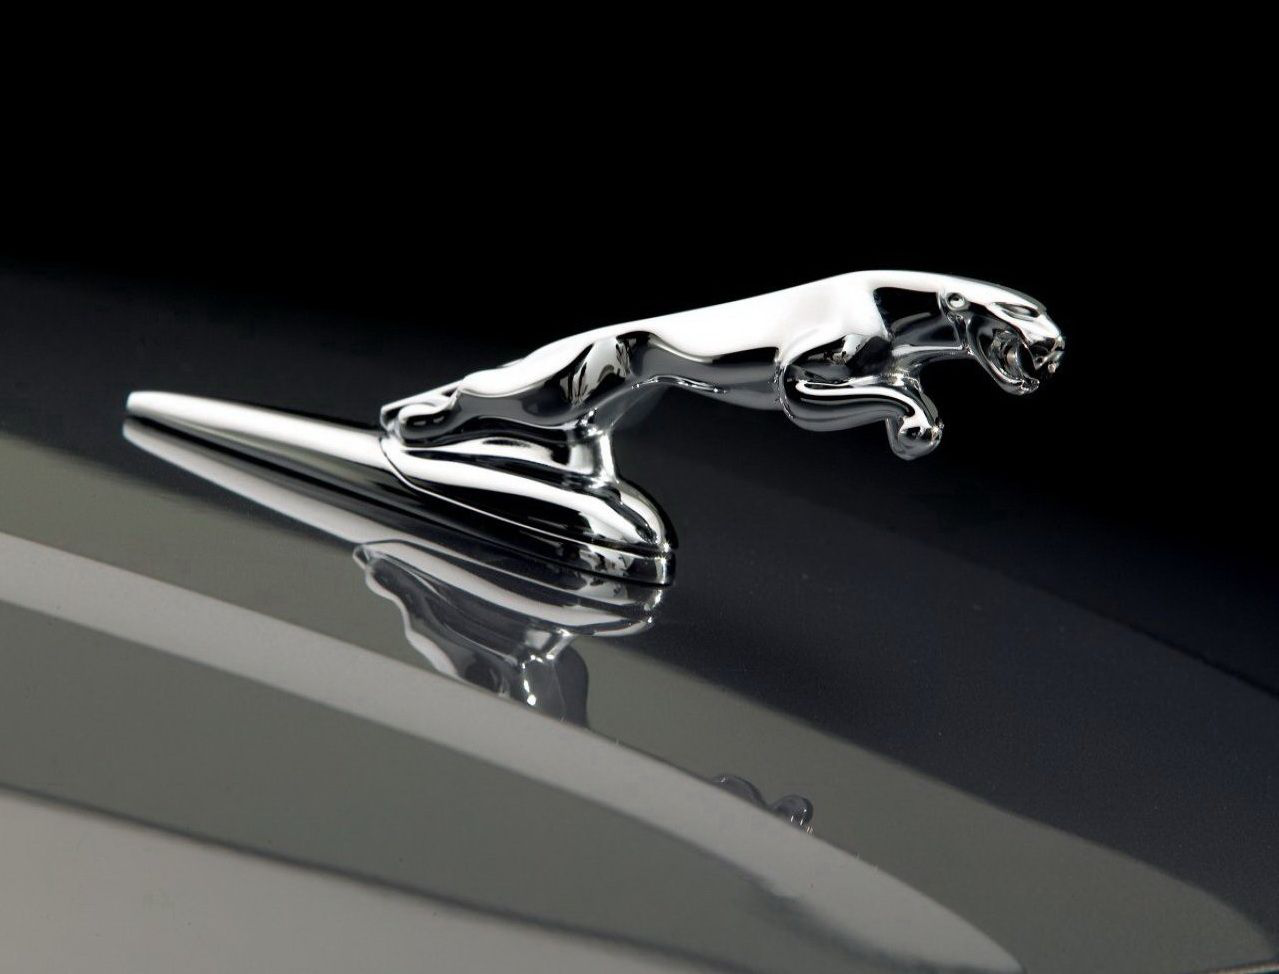

In [0]:
img = open_image(urlopen('https://i.pinimg.com/originals/2a/0b/ef/2a0bef9af781bef4398eee50a49a7023.jpg'))
img

In [0]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category jaguars

## Homework exercise 3 (4 points): Create your own dataset and build a CNN model using fast.ai API
<font color='red'> In this exercise, you have a chance to test if CNN can distinguish between images of your favourite objects. </font>

<font color='red'> **(a)** Create your own dataset with two or more classes using the same approach we used in the class to construct the dataset of wild cats. But this time choose classes yourself. **(2 points)** </font>

In [135]:
# code cell to upload data files in separate cell since nee to be run multiple times for each *.csv file
from google.colab import files
uploaded = files.upload()

Saving camaro.csv to camaro.csv


In [136]:
##### YOUR CODE STARTS #####
# creating folders for data
folder = 'camaro'
file = 'camaro.csv'

path = Path('data/muscle_cars')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

folder = 'charger'
file = 'charger.csv'

path = Path('data/muscle_cars')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

path.ls()
#downloading images
folder = 'camaro'
dest = path/folder
download_images('camaro.csv', dest, max_pics=400)

folder = 'charger'
dest = path/folder
download_images('charger.csv', dest, max_pics=400)

classes = ['camaro','charger']

for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)
# creating image dataset
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

##### YOUR CODE ENDS ##### (please do not delete this line)

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '': No schema supplied. Perhaps you meant http://?
Error  Invalid URL '

charger


Test that data is correctly formatted and accessible by running the following lines:

In [137]:
data.classes

['camaro', 'charger']

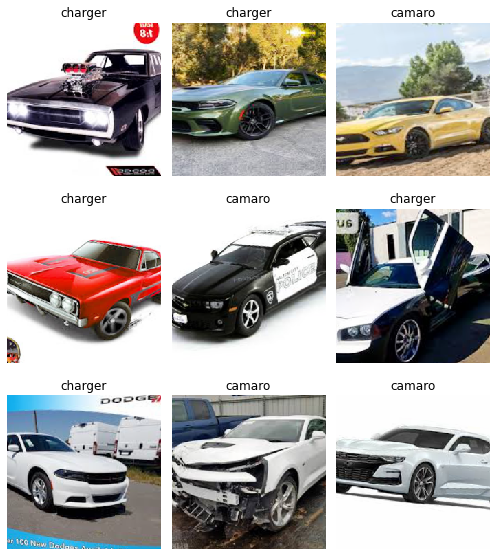

In [138]:
data.show_batch(rows=3, figsize=(7,8))

In [139]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['camaro', 'charger'], 2, 512, 128)

<font color='red'> **(b)** train a neural network on images you have acquired **(1 point)** </font>

In [140]:
##### YOUR CODE STARTS #####
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.fit_one_cycle(5)
interp = ClassificationInterpretation.from_learner(learn)
##### YOUR CODE ENDS ##### (please do not delete this line)

Plot the confusion matrix to make sure that you model has learned something:

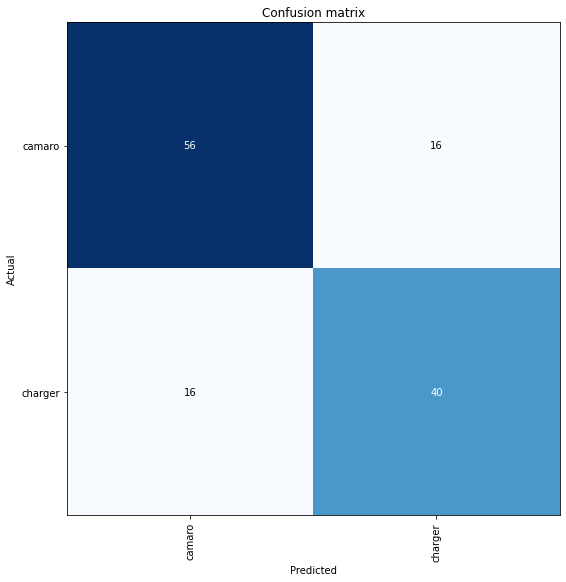

In [141]:
interp.plot_confusion_matrix()

<font color='red'> **(c)** Test your model on one or more images from the internet that represent classes you have chosen, but unlikely to be in the training data (you can change your search query). **(1 point)** </font>

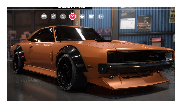

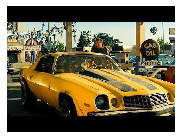

In [142]:
##### YOUR CODE STARTS #####
from urllib.request import urlopen
img1 = open_image(urlopen('https://i.ytimg.com/vi/sOeDPyX4FL0/maxresdefault.jpg')) #for check taking a picture from a NFS game with restyling. True label: charger
img2 = open_image(urlopen('https://i.ytimg.com/vi/hdHHXON55do/hqdefault.jpg')) #for check taking a picture from a Transforer movie with old car. True label: camaro
img1.show()
img2.show()
##### YOUR CODE ENDS ##### (please do not delete this line)

In [143]:
#clightly modify code to show both results simultaneously
pred_class1,pred_idx,outputs = learn.predict(img1)
pred_class2,pred_idx,outputs = learn.predict(img2)
pred_class1, pred_class2

(Category charger, Category charger)

# Bonus exercises
*(NB, these are optional exercises!)*

## Bonus exercise 1 (3 bonus points):

<font color='red'> Take `RandomForestClassifier` or some other model from sklearn package and apply it to the spiral data from the homework exercise 1. Visualise trained algorithm the same way as we have visualised neural networks (by changing the `plot_neural_network` function). Compare your model and the 2-layer or 3-layer neural network. How different are the performances? How different are the decision boundaries? Why? </font> 

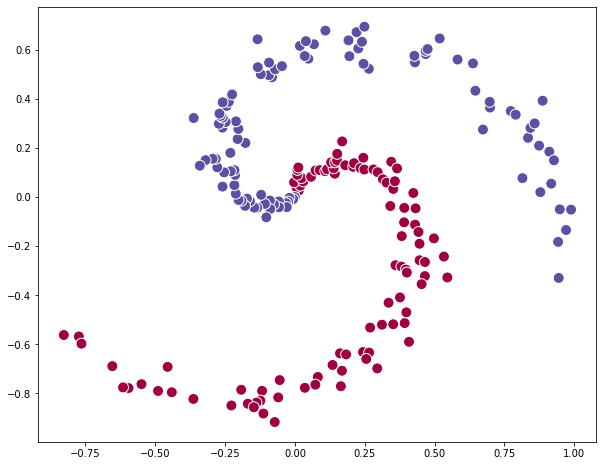

In [144]:
#regenerating data like in first exercise since variables got overwritten
N = 100 # number of points per class
D = 2 # dimensionality
K = 2 # number of classes (purple and red circles)
X = np.zeros((N*K,D)) # data matrix (each row = single example)
num_examples = X.shape[0]
y = np.zeros(N*K, dtype='uint8') # class labels

# Adding some geometry
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=120, edgecolors = 'white', cmap=plt.cm.Spectral)
plt.show()

In [145]:
from sklearn import svm
clf = svm.SVC() #by default uses rbf kernel
clf.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
def plot_SVC(X, y, clf):
  h = 0.02
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                       np.arange(y_min, y_max, h))
  
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

  Z = Z.reshape(xx.shape)
  fig = plt.figure()
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=120, edgecolors = 'white', cmap=plt.cm.Spectral)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

In [147]:
print('Training accuracy: %.2f' % clf.score(X, y))

Training accuracy: 0.99


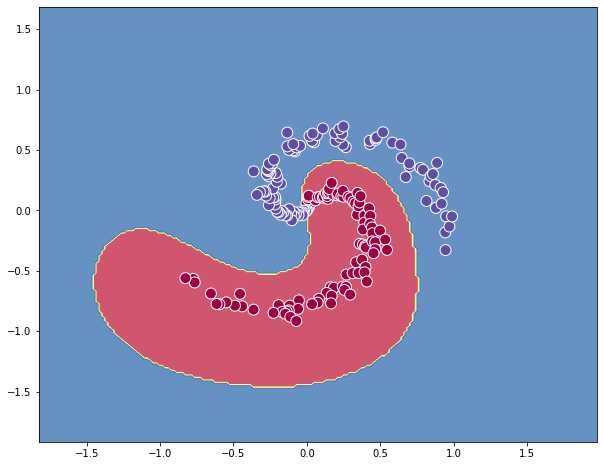

In [148]:
# plot the resulting classifier
plot_SVC(X, y, clf)

If we compare SVC to 3-layers network from excercise 1 we could notice that SVC classifier fitted much faster compare to 3-layers network. I think main reason here is that backpropagation steps slows down neural network training, since it is computational expensive task.  

Also, using SVC with default RBF (Radial Basis Function) kernel we could see on the plot completely different decision boundry polygon. In case of SVC we could see it as smooth rounded shape which follows the spiral distribution of data, however it describe data near the center not ideally - where both classes meet each other. I think reason for this hidden in how RBF and SVC works altogether. SVC relies on so called support vectors (subset of training data) which serve as basis and RBF is a redial function which applied to those support vectors. That is why we got such kind of shape as result. Main difference in shape of decision boundary compared to 3-layer network is that decision region is centered atround points of one class only considering all other space as another class, while 3-layer Neural network devided the whole space in two roughly equal parts. Again, reason for such behavior is exactly same - radial functions are applied to support vectors, which are subset of training data points. As result, decision boundary wrap around data of one class and with assumption that everything outside of that region belongs to another class.

# Comments (optional feedback to the course instructors)
Here, please, leave your comments regarding the homework, possibly answering the following questions: 
* how much time did you spend on this homework?
* was it too hard/easy for you?
* what would you suggest to add or remove?
* anything else you would like to tell us

Your comments:
*   This was an easiest homework ever. Could be done in 1-2 hours, but I am a slowpoke, that is why handle it in 3 hours approximately.
*   This one was super easy. Bonus exercise also not a challange at all. I would love to havde here kaggle exercise as it was in HW1.
*   Another kaggle challange about vanila deep learning or CNN simillar to what we have in HW1. Also I am really missing GAN networks as part of this classroom\homework.
*   Overall I will be missing candy throwing due to stupid virus :(. ANother suggestion I have should we consider some kaggle online\in class\other variant challange in end of April\May as we discussed in the beggining?





# References
* A very large part of this notebook has been inspired by http://cs231n.github.io/neural-networks-case-study/ developed by karpathy@cs.stanford.edu.
* CIFAR10 part of this practice has been inspired by the Machine Learning course taught at the University of Tartu by Meelis Kull (https://courses.cs.ut.ee/2019/ml/fall)
* Fast.ai part has been copied from https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb. My general recommendation for everyone intersted in Deep Learning (not only in fast.ai library) to take fast.ai  online course for coders: https://course.fast.ai/ developed by Jeremy Howard et al.